### Imports

In [2]:
import argparse
import os.path as osp

import torch
import torch.nn.functional as F
from torch.nn import Linear

import torch_geometric.transforms as T
from torch_geometric.datasets import MovieLens
from torch_geometric.nn import SAGEConv, to_hetero

import matplotlib.pyplot as plt

/Users/ioannisathanasiou/diploma/environ/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

path = osp.join('../../data/MovieLens')
dataset = MovieLens(path, model_name='all-MiniLM-L6-v2')
data = dataset[0].to(device)

# Add user node features for message passing:
data['user'].x = torch.eye(data['user'].num_nodes, device=device)
del data['user'].num_nodes

# Add a reverse ('movie', 'rev_rates', 'user') relation for message passing:
data = T.ToUndirected()(data)
del data['movie', 'rev_rates', 'user'].edge_label  # Remove "reverse" label.

# Perform a link-level split into training, validation, and test edges:
train_data, val_data, test_data = T.RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    neg_sampling_ratio=0.0,
    edge_types=[('user', 'rates', 'movie')],
    rev_edge_types=[('movie', 'rev_rates', 'user')],
)(data)

### Model

In [4]:
class GNNEncoder(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv((-1, -1), hidden_channels)
        self.conv2 = SAGEConv((-1, -1), out_channels)
        self.conv3 = SAGEConv((-1, -1), out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = F.dropout(x, p=0.1, training=self.training)
        x = self.conv2(x, edge_index).relu()
        x = F.dropout(x, p=0.1, training=self.training)
        x = self.conv3(x, edge_index)
        return x


class EdgeDecoder(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.lin1 = Linear(2 * hidden_channels, hidden_channels)
        self.lin2 = Linear(hidden_channels, hidden_channels)
        self.lin3 = Linear(hidden_channels, hidden_channels)
        self.lin4 = Linear(hidden_channels, 1)

    def forward(self, z_dict, edge_label_index):
        row, col = edge_label_index
        z = torch.cat([z_dict['user'][row], z_dict['movie'][col]], dim=-1)

        z = self.lin1(z).relu()
        z = F.dropout(z, p=0.1, training=self.training)
        z = self.lin2(z).relu()
        z = F.dropout(z, p=0.1, training=self.training)
        z = self.lin3(z).relu()
        z = F.dropout(z, p=0.1, training=self.training)
        z = self.lin4(z)
        return z.view(-1)


class Model(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.encoder = GNNEncoder(hidden_channels, hidden_channels)
        self.encoder = to_hetero(self.encoder, data.metadata(), aggr='sum')
        self.decoder = EdgeDecoder(hidden_channels)

    def forward(self, x_dict, edge_index_dict, edge_label_index):
        z_dict = self.encoder(x_dict, edge_index_dict)
        return self.decoder(z_dict, edge_label_index)

### Train-test functions

In [6]:
def train_test(model, use_weighted_loss, epochs=50):
    latest_predictions = []

    if use_weighted_loss:
        weight = torch.bincount(train_data['user', 'movie'].edge_label)
        weight = weight.max() / weight
    else:
        weight = None

    def weighted_mse_loss(pred, target, weight=None):
        weight = 1. if weight is None else weight[target].to(pred.dtype)
        return (weight * (pred - target.to(pred.dtype)).pow(2)).mean()

    with torch.no_grad():
        model.encoder(train_data.x_dict, train_data.edge_index_dict)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


    def train():
        model.train()
        optimizer.zero_grad()
        pred = model(train_data.x_dict, train_data.edge_index_dict,
                    train_data['user', 'movie'].edge_label_index)
        target = train_data['user', 'movie'].edge_label
        loss = weighted_mse_loss(pred, target, weight)
        loss.backward()
        optimizer.step()
        return float(loss)


    @torch.no_grad()
    def test(data):
        nonlocal latest_predictions
        model.eval()
        pred = model(data.x_dict, data.edge_index_dict,
                    data['user', 'movie'].edge_label_index)
        pred = pred.clamp(min=0, max=5)
        latest_predictions = pred
        target = data['user', 'movie'].edge_label.float()
        rmse = F.mse_loss(pred, target).sqrt()
        return float(rmse)

    for epoch in range(1, epochs):
        loss = train()
        train_rmse = test(train_data)
        val_rmse = test(val_data)
        test_rmse = test(test_data)
        if not epoch % 5:
            print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train: {train_rmse:.4f}, '
                f'Val: {val_rmse:.4f}, Test: {test_rmse:.4f}')
    
    return latest_predictions


### Experiments on MovieLens with weighted and unweighted loss

Epoch: 005, Loss: 7.1850, Train: 1.1086, Val: 1.1086, Test: 1.1137
Epoch: 010, Loss: 6.6206, Train: 1.3249, Val: 1.3510, Test: 1.3615
Epoch: 015, Loss: 6.3904, Train: 1.6858, Val: 1.7120, Test: 1.6958
Epoch: 020, Loss: 6.2374, Train: 1.2126, Val: 1.2291, Test: 1.2324
Epoch: 025, Loss: 5.8236, Train: 1.3766, Val: 1.4023, Test: 1.3936
Epoch: 030, Loss: 5.3692, Train: 1.4057, Val: 1.4313, Test: 1.4295
Epoch: 035, Loss: 4.8752, Train: 1.2935, Val: 1.3146, Test: 1.3165
Epoch: 040, Loss: 4.3251, Train: 1.3590, Val: 1.3703, Test: 1.3643
Epoch: 045, Loss: 4.1487, Train: 1.2524, Val: 1.2684, Test: 1.2641
Epoch: 050, Loss: 3.9483, Train: 1.1620, Val: 1.1900, Test: 1.1843
Epoch: 055, Loss: 3.8432, Train: 1.2565, Val: 1.2673, Test: 1.2727
Epoch: 060, Loss: 3.7748, Train: 1.2031, Val: 1.2332, Test: 1.2500
Epoch: 065, Loss: 3.6881, Train: 1.2649, Val: 1.3202, Test: 1.3073
Epoch: 070, Loss: 3.6471, Train: 1.2553, Val: 1.3156, Test: 1.2877
Epoch: 075, Loss: 3.5455, Train: 1.1452, Val: 1.1725, Test: 1.

(array([ 207.,  400.,  545.,  938., 1680., 2429., 2239., 1275.,  355.,
          15.]),
 array([0.21568973, 0.69412076, 1.17255175, 1.65098286, 2.12941384,
        2.60784483, 3.08627582, 3.5647068 , 4.04313803, 4.52156878,
        5.        ]),
 <BarContainer object of 10 artists>)

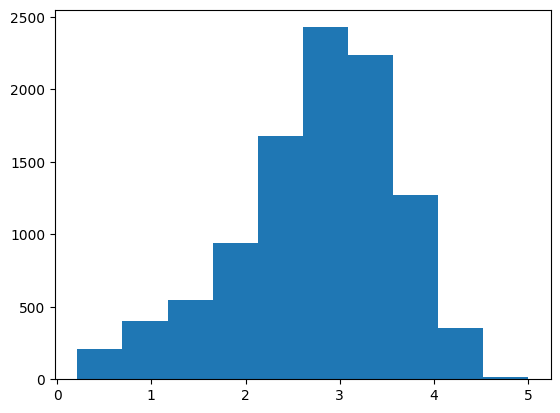

In [10]:
model = Model(hidden_channels=32).to(device)
preds = train_test(model, use_weighted_loss=True, epochs=500)
plt.hist(preds)

Epoch: 005, Loss: 2.1835, Train: 1.5688, Val: 1.5568, Test: 1.5575
Epoch: 010, Loss: 1.9310, Train: 1.5669, Val: 1.5822, Test: 1.5666
Epoch: 015, Loss: 1.1520, Train: 1.2203, Val: 1.2188, Test: 1.2165
Epoch: 020, Loss: 1.1044, Train: 1.1084, Val: 1.1236, Test: 1.1110
Epoch: 025, Loss: 1.1661, Train: 1.0316, Val: 1.0436, Test: 1.0357
Epoch: 030, Loss: 1.0938, Train: 1.0181, Val: 1.0285, Test: 1.0225
Epoch: 035, Loss: 1.0693, Train: 1.0137, Val: 1.0277, Test: 1.0197
Epoch: 040, Loss: 1.0231, Train: 0.9995, Val: 1.0089, Test: 1.0064
Epoch: 045, Loss: 0.9810, Train: 0.9850, Val: 0.9994, Test: 0.9934


(array([   8.,   73.,  183.,  745., 1704., 2717., 2663., 1516.,  426.,
          48.]),
 array([1.86045384, 2.13707447, 2.41369486, 2.69031525, 2.96693587,
        3.2435565 , 3.52017689, 3.79679728, 4.07341766, 4.35003853,
        4.62665892]),
 <BarContainer object of 10 artists>)

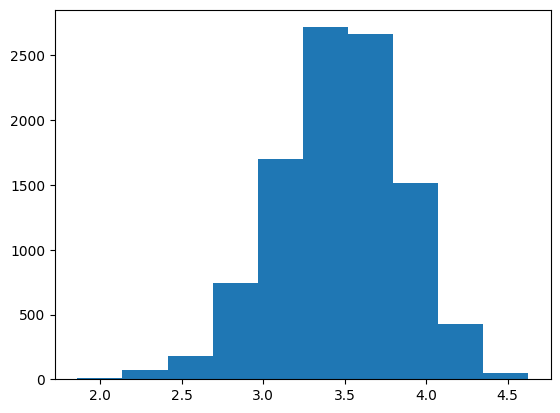

In [6]:
model = Model(hidden_channels=32).to(device)
preds = train_test(model, use_weighted_loss=False)
plt.hist(preds)